# プログラミング基礎演習レポート 2024
このノートブックでは、以下の4つの課題に取り組んだ。


1.   課題（必須課題）txtデータ
2.   課題（自由課題）wav音声
3.   課題（自由課題）png画像
4.   課題（自由課題）EDM3信号

各課題で共通となるIndependent Component Analysis (ICA)や下処理の実装は、関数として実装して利用した。

## データ準備

Google Colaboratoryで実行したため、Googleドライブから配布データを取得し、展開するようにした。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/Colab Notebooks/プログラミング基礎演習/final/data.zip" .
!unzip data.zip

Mounted at /content/drive
Archive:  data.zip
  inflating: image2.png              
  inflating: image1.png              
  inflating: dat1.txt                
  inflating: dat2.txt                
  inflating: speechA1.wav            
  inflating: speechA2.wav            
  inflating: speechB1.wav            
  inflating: speechB2.wav            
  inflating: speechB3.wav            
  inflating: music1.wav              
  inflating: music2.wav              


## ICA・下処理の実装

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Audio
np.random.seed(1234)

In [3]:
import sys
print(np.__version__)
print(sp.__version__)
print(sys.version)

1.26.4
1.13.1
3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [4]:
# 各系列（チャンネル）の平均を0にする
def adjust_means(X):
    # https://note.nkmk.me/python-numpy-axis-keepdims/
    return X - np.mean(X, axis=1, keepdims=True)

# 白色化
def whiten(X):
    n = X.shape[1]
    S = X @ X.T / n
    eigvals, E = np.linalg.eig(S) # 第11回資料
    # https://runebook.dev/ja/docs/numpy/reference/generated/numpy.reciprocal
    D0 = np.diag(np.reciprocal(np.sqrt(eigvals)))
    V = E @ D0 @ E.T
    return V @ X

In [5]:
# 観測値の数だけ重みを作成しているが、直交化等はしていないので同じ信号源が得られる可能性がある
def ICA(X, max_iter=1000, eps=0.1):
    n = X.shape[1]
    W = np.random.randn(X.shape[0], X.shape[0])
    # https://www.mathpython.com/numpy-vector-norm
    W = W / np.linalg.norm(W, axis=1)
    for i in range(X.shape[0]):
        w = W[i]
        w_prev = np.zeros_like(w)

        for iter in range(max_iter):
            w = w.reshape(w.shape[0], 1).squeeze()
            w = w / np.linalg.norm(w)
            y = w.T @ X
            w = (X * (y**3)).mean(axis=1) - 3 * w
            w = w / np.linalg.norm(w)
            diff = np.linalg.norm(w - w_prev)
            if diff < eps:
                print(f"trial: {i} iter: {iter}/{max_iter} early break")
                break
            elif iter % 1000 == 0:
                print(f"trial: {i} iter: {iter}/{max_iter} diff: {diff}")
            w_prev = w.copy()

        W[:,i] = w.T

    # 元の信号を求める
    Y = W @ X
    return Y, W

## 1. 課題（必須課題）txtデータ

In [6]:
x1 = np.loadtxt("dat1.txt")
x2 = np.loadtxt("dat2.txt")
X = np.array([x1, x2])
X.shape

(2, 3142)

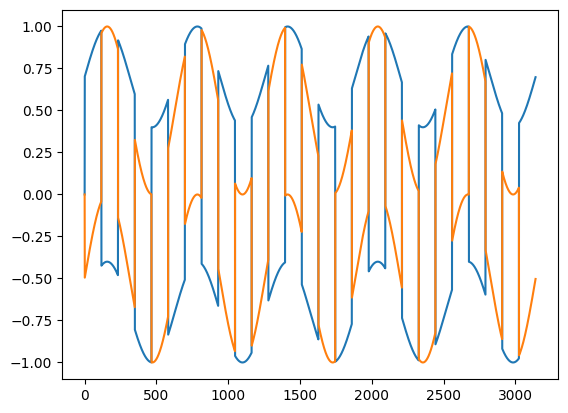

In [7]:
%matplotlib inline
plt.plot(x1)
plt.plot(x2)

In [8]:
X = adjust_means(X)
Z = whiten(X)

In [9]:
%%time
Y, W = ICA(Z)

trial: 0 iter: 0/1000 diff: 1.0
trial: 1 iter: 0/1000 diff: 1.0
CPU times: user 525 ms, sys: 5.99 ms, total: 531 ms
Wall time: 688 ms


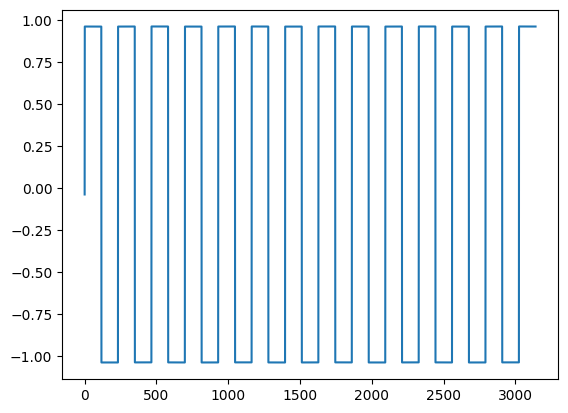

In [10]:
%matplotlib inline
plt.plot(Y[0])
plt.savefig("dat_ICA1.png")

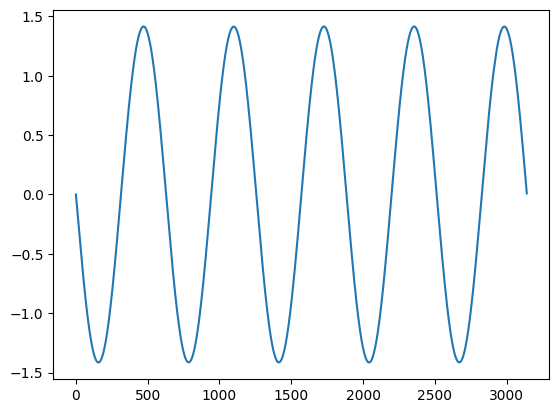

In [11]:
%matplotlib inline
plt.plot(Y[1])
plt.savefig("dat_ICA2.png")

## 2. 課題（自由課題）wav音声

### speechA1.wav, speechA2.wav

In [12]:
a1_wav = sp.io.wavfile.read("speechA1.wav")
a2_wav = sp.io.wavfile.read("speechA2.wav")
a1 = a1_wav[1]
a2 = a2_wav[1]
X = np.array([a1, a2])
X.shape
X = adjust_means(X)
Z = whiten(X)

In [13]:
%%time
Y, W = ICA(Z, eps=0.05)

trial: 0 iter: 0/1000 diff: 1.0
trial: 0 iter: 4/1000 early break
trial: 1 iter: 0/1000 diff: 1.0
trial: 1 iter: 2/1000 early break
CPU times: user 48.3 ms, sys: 44 ms, total: 92.3 ms
Wall time: 50.1 ms


In [15]:
Y1 = Y / np.max(Y, axis=1, keepdims=True) * np.max(X, axis=1, keepdims=True)
sp.io.wavfile.write("speechA_ICA1.wav", a1_wav[0], Y1[0].astype(np.int16))
sp.io.wavfile.write("speechA_ICA2.wav", a2_wav[0], Y1[1].astype(np.int16))

#### 音声プレイヤー

In [16]:
Audio("speechA1.wav")

In [17]:
Audio("speechA_ICA1.wav")

In [18]:
Audio("speechA_ICA2.wav")

### speechB1.wav, speechB2.wav, speechB3.wav

In [19]:
b1_wav = sp.io.wavfile.read("speechB1.wav")
b2_wav = sp.io.wavfile.read("speechB2.wav")
b3_wav = sp.io.wavfile.read("speechB3.wav")
X = np.array([b1_wav[1], b2_wav[1], b3_wav[1]])
X.shape
X = adjust_means(X)
Z = whiten(X)

In [20]:
%%time
Y, W = ICA(Z, eps=0.05)

trial: 0 iter: 0/1000 diff: 1.0
trial: 0 iter: 2/1000 early break
trial: 1 iter: 0/1000 diff: 0.9999999999999999
trial: 1 iter: 1/1000 early break
trial: 2 iter: 0/1000 diff: 1.0
trial: 2 iter: 3/1000 early break
CPU times: user 66.6 ms, sys: 53.7 ms, total: 120 ms
Wall time: 63.3 ms


In [25]:
Y1 = Y / np.max(Y, axis=1, keepdims=True) * np.max(X, axis=1, keepdims=True)
sp.io.wavfile.write("speechB_ICA1.wav", b1_wav[0], Y1[0].astype(np.int16))
sp.io.wavfile.write("speechB_ICA2.wav", b2_wav[0], Y1[1].astype(np.int16))
sp.io.wavfile.write("speechB_ICA3.wav", b3_wav[0], Y1[2].astype(np.int16))

#### 音声プレイヤー

In [22]:
Audio("speechB1.wav")

In [26]:
Audio("speechB_ICA1.wav")

In [27]:
Audio("speechB_ICA2.wav")

In [28]:
Audio("speechB_ICA3.wav")

### music1.wav, music2.wav

In [29]:
m1_wav = sp.io.wavfile.read("music1.wav")
m2_wav = sp.io.wavfile.read("music2.wav")
X = np.array([m1_wav[1], m2_wav[1]])
X.shape
X = adjust_means(X)
Z = whiten(X)

In [30]:
%%time
Y, W = ICA(Z, eps=0.05)

trial: 0 iter: 0/1000 diff: 1.0
trial: 0 iter: 1/1000 early break
trial: 1 iter: 0/1000 diff: 1.0
trial: 1 iter: 1/1000 early break
CPU times: user 207 ms, sys: 175 ms, total: 382 ms
Wall time: 201 ms


In [33]:
Y1 = Y / np.max(Y, axis=1, keepdims=True) * np.max(X, axis=1, keepdims=True)
sp.io.wavfile.write("music_ICA1.wav", m1_wav[0], Y1[0].astype(np.int16))
sp.io.wavfile.write("music_ICA2.wav", m2_wav[0], Y1[1].astype(np.int16))

#### 音声プレイヤー

In [32]:
Audio("music1.wav")

Output hidden; open in https://colab.research.google.com to view.

In [34]:
Audio("music_ICA1.wav")

Output hidden; open in https://colab.research.google.com to view.

In [35]:
Audio("music_ICA2.wav")

Output hidden; open in https://colab.research.google.com to view.

## 3. 課題（自由課題）png画像

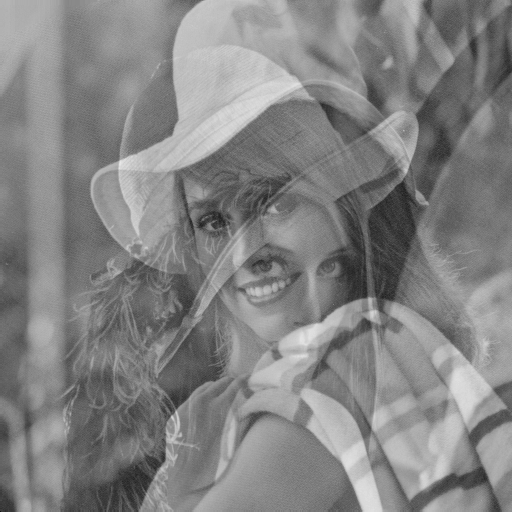

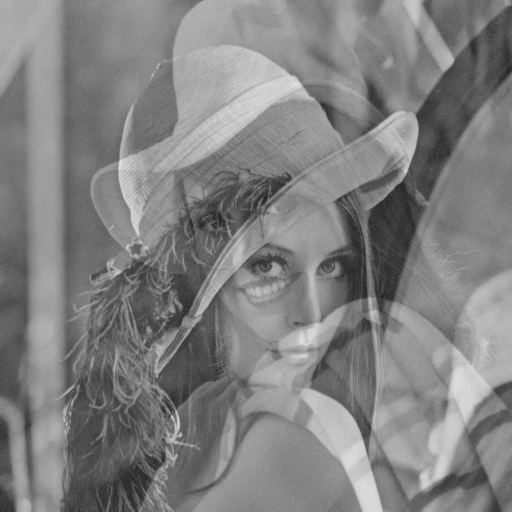

In [36]:
img1 = Image.open("image1.png")
img2 = Image.open("image2.png")
display(img1)
display(img2)

In [37]:
# https://qiita.com/kenichiro-yamato/items/c911457adb7af10ed1b5
x1 = np.array(img1).reshape(1, -1)
x2 = np.array(img2).reshape(1, -1)
X = np.array([x1, x2]).reshape(2, -1)
X.shape
X = adjust_means(X)
Z = whiten(X)

In [47]:
%%time
Y, W = ICA(Z)

trial: 0 iter: 0/1000 diff: 0.9999999999999999
trial: 1 iter: 0/1000 diff: 1.0
CPU times: user 29 s, sys: 21.1 s, total: 50.1 s
Wall time: 29.8 s


In [48]:
y1 = (Y[0].reshape(img1.size) - np.min(Y[0])) / (np.max(Y[0]) - np.min(Y[0])) * 255
y2 = (Y[1].reshape(img2.size) - np.min(Y[1])) / (np.max(Y[1]) - np.min(Y[1])) * 255

In [49]:
img1_ICA = Image.fromarray(y1.astype(np.uint8))
img2_ICA = Image.fromarray(y2.astype(np.uint8))
# save images
img1_ICA.save("image_ICA1.png")
img2_ICA.save("image_ICA2.png")

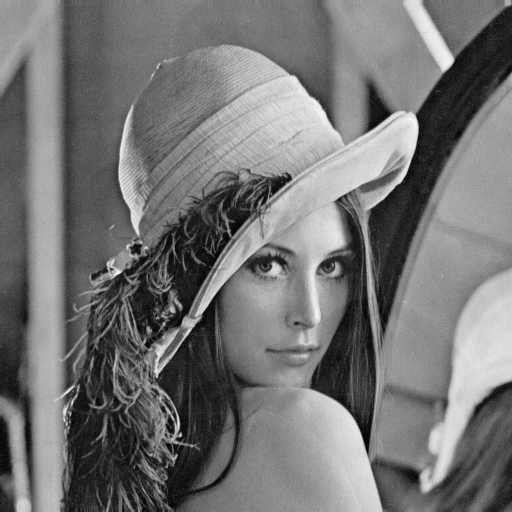

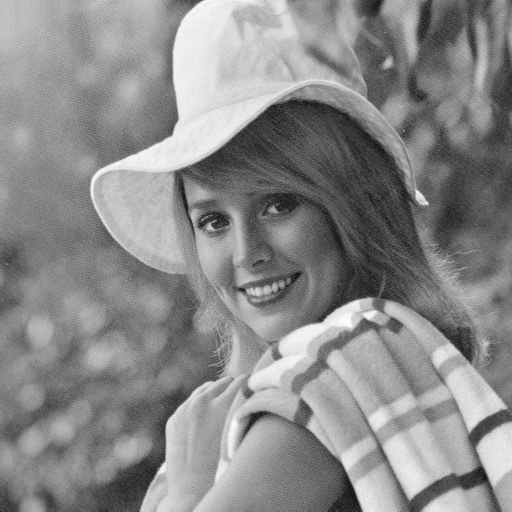

In [50]:
display(img1_ICA)
display(img2_ICA)

## 4. 課題（自由課題）EDM3音声

- 音源1 https://www.youtube.com/watch?v=2Kk165fkl38
- 音源2 https://ncs.io/skyhigh
- 音源3 https://ncs.io/SkyHigh2

### カスタムデータ準備

In [52]:
!cp "/content/drive/MyDrive/Colab Notebooks/プログラミング基礎演習/final/Elektronomia - Sky High [NCS Release].mp3" .
!cp "/content/drive/MyDrive/Colab Notebooks/プログラミング基礎演習/final/Elektronomia - Sky High pt. II [NCS Release].mp3" .
!cp "/content/drive/MyDrive/Colab Notebooks/プログラミング基礎演習/final/Elektronomia x Alan Walker - Sky High x Spectre x Sky High pt. II.wav" .

In [53]:
!ffmpeg -i "Elektronomia - Sky High [NCS Release].mp3" "Elektronomia - Sky High [NCS Release].wav"
!ffmpeg -i "Elektronomia - Sky High pt. II [NCS Release].mp3" "Elektronomia - Sky High pt. II [NCS Release].wav"
!ffmpeg -i "Elektronomia x Alan Walker - Sky High x Spectre x Sky High pt. II.wav" -ar 44100 "Elektronomia x Alan Walker - Sky High x Spectre x Sky High pt. II_44100Hz.wav"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

### 処理

In [97]:
a1_wav = sp.io.wavfile.read("Elektronomia - Sky High [NCS Release].wav")
a2_wav = sp.io.wavfile.read("Elektronomia - Sky High pt. II [NCS Release].wav")
a3_wav = sp.io.wavfile.read("Elektronomia x Alan Walker - Sky High x Spectre x Sky High pt. II_44100Hz.wav")
print(a1_wav[0], a2_wav[0], a3_wav[0])
a1 = a1_wav[1]
a2 = a2_wav[1]
a3 = a3_wav[1]
# ステレオなので平均を取る
a1 = np.mean(a1, axis=1)
a2 = np.mean(a2, axis=1)
a3 = np.mean(a3, axis=1)
print(a1.shape, a2.shape, a3.shape)

44100 44100 44100
(10420992,) (10919808,) (10099201,)


In [98]:
a1 = a1[:1000000]
a2 = a2[:1000000]
a3 = a3[:1000000]

In [99]:
np.max(a1), np.min(a1), np.max(a2), np.min(a2), np.max(a3), np.min(a3)

(32767.0, -32768.0, 32767.0, -32768.0, 31025.5, -31976.0)

In [100]:
a1 = (a1 - np.min(a1)) / (np.max(a1) - np.min(a1)) * 2 - 1
a2 = (a2 - np.min(a2)) / (np.max(a2) - np.min(a2)) * 2 - 1
a3 = (a3 - np.min(a3)) / (np.max(a3) - np.min(a3)) * 2 - 1

In [101]:
X = np.array([a1, a2, a3])
X.shape

(3, 1000000)

In [102]:
X = adjust_means(X)
Z = whiten(X)

In [103]:
Y, W = ICA(Z)

trial: 0 iter: 0/1000 diff: 1.0
trial: 0 iter: 4/1000 early break
trial: 1 iter: 0/1000 diff: 1.0
trial: 1 iter: 8/1000 early break
trial: 2 iter: 0/1000 diff: 1.0
trial: 2 iter: 1/1000 early break


In [104]:
Y1 = Y / np.max(Y, axis=1, keepdims=True) * 32000

In [105]:
sp.io.wavfile.write("EDM_ICA1.wav", 44100, Y1[0].astype(np.int16))
sp.io.wavfile.write("EDM_ICA2.wav", 44100, Y1[1].astype(np.int16))
sp.io.wavfile.write("EDM_ICA3.wav", 44100, Y1[2].astype(np.int16))

### 再生

In [ ]:
Audio("Elektronomia - Sky High [NCS Release].wav")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Audio("Elektronomia - Sky High pt. II [NCS Release].wav")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Audio("Elektronomia x Alan Walker - Sky High x Spectre x Sky High pt. II_44100Hz.wav")

Output hidden; open in https://colab.research.google.com to view.

In [106]:
Audio("EDM_ICA1.wav")

Output hidden; open in https://colab.research.google.com to view.

In [107]:
Audio("EDM_ICA2.wav")

Output hidden; open in https://colab.research.google.com to view.

In [108]:
Audio("EDM_ICA3.wav")

Output hidden; open in https://colab.research.google.com to view.